In [2]:
import numpy as np
'''with open('./data_update_2channels.npy', 'rb') as f:
    Data = np.load(f)

with open('./data_update_2channels_test.npy', 'rb') as f:
    test_D = np.load(f)
test_D = test_D.reshape((test_D.shape[0], test_D.shape[1], 1))
'''
with open('./data_update_2channels_test_09042023.npy', 'rb') as f:
    Data = np.load(f)
Data = Data.reshape((Data.shape[0], Data.shape[1], 1))

In [3]:
import sys
print(sys.version)

3.9.12 (tags/v3.9.12:b28265d, Mar 23 2022, 23:52:46) [MSC v.1929 64 bit (AMD64)]


In [4]:
import os
from os import walk

def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".txt"):
                data = np.genfromtxt(root+'/'+file)
                (row,) = data.shape
                col = 1
                count += 1
            elif count != 0 and file.endswith(".txt"):
                data1 = np.genfromtxt(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = data.reshape((count, row, col))
    return data, count

In [5]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler

c11,_,_= Data.shape

print(Data.shape)
D1 = shuffle(Data, random_state=0)
RoundC = round(c11*0.6)+1
RoundC2 = round(c11*0.8)+1
# Traning: 36000, Validation: 12000, Testing: 11999
D_Train = D1[:RoundC, :,:]
D_Valid = D1[RoundC:RoundC2,:,:]
D_Test = D1[RoundC2:,:,:]

(151365, 1030, 1)


In [6]:
def data_preprocessing(dataset):
    data = np.zeros([len(dataset),16,32,2])
    data2 = np.zeros([len(dataset),16,1,8])
    data[:,:,:16,0] = dataset[:,:16*16].reshape((-1,16,16))
    data[:,:,:16,1] = dataset[:,16*16*2:16*16*3].reshape((-1,16,16))
    data[:,:,16:,0] = dataset[:,16*16:16*16*2].reshape((-1,16,16))   
    data[:,:,16:,1] = dataset[:,16*16*3:16*16*4].reshape((-1,16,16))

    for i in range(16):
        for j in range(16):
            data2[:,i,0,0] += data[:,i,j,0]
            data2[:,i,0,2] += data[:,i,j,1]
            data2[:,i,0,1] += data[:,j,i,0]
            data2[:,i,0,3] += data[:,j,i,1]
            data2[:,i,0,4] += data[:,i,16+j,0]
            data2[:,i,0,6] += data[:,i,16+j,1]
            data2[:,i,0,5] += data[:,j,16+i,0]
            data2[:,i,0,7] += data[:,j,16+i,1]
    print(np.max(data2))
    data2 = data2/11
    original_position = dataset[:,-3:,0]
    final_position=dataset[:,-6:-3,0] + dataset[:,-3:,0]
    label = np.concatenate([original_position, final_position], axis=1)
    
    return data2, original_position, final_position, label

train_data, train_data_original_position, train_data_final_position, train_label = data_preprocessing(D_Train)
valid_data, valid_data_original_position, valid_data_final_position, valid_label = data_preprocessing(D_Valid)
test_data, test_data_original_position, test_data_final_position, test_label = data_preprocessing(D_Test)

11.0
11.0
11.0


In [7]:
print(np.max(train_data))

1.0


In [8]:
# Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(train_label)
train_label_scaled = scaler.transform(train_label)
valid_label_scaled = scaler.transform(valid_label)
test_label_scaled = scaler.transform(test_label)

#scaler2 = MinMaxScaler(feature_range=(0,1)).fit(train_data)
#train_data_scaled = scaler2.transform(train_data)
#valid_data_scaled = scaler2.transform(valid_data)
#test_data_scaled = scaler2.transform(test_data)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_data_original_position.shape)
print(valid_data_final_position.shape)
print(test_data_final_position.shape)
print(train_label.shape)    

(90820, 16, 1, 8)
(30273, 16, 1, 8)
(30272, 16, 1, 8)
(90820, 3)
(30273, 3)
(30272, 3)
(90820, 6)


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, AvgPool2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
import tensorflow.keras.backend as K

class ShareCNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.cnn1 = Conv2D(4, (3,1),  padding="same", input_shape=(16, 1, 4), activation="relu")        
        self.cnn2 = Conv2D(8, (3,1),  padding="same", activation="relu")
        self.pooling = AvgPool2D(pool_size=(2,1))
        
    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.pooling(x)
        x = self.cnn2(x)
        x = self.pooling(x)
        return x

    
class OurModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.sharecnn = ShareCNN()
        self.cnn1 = Conv2D(16,  (3,1),  padding="same", activation="relu")
        self.pooling = AvgPool2D(pool_size=(2,1))       
        self.dense1 = Dense(32, activation='relu')
        self.dense2 = Dense(16, activation='relu')
        self.dense3 = Dense(6, activation='sigmoid')        
        
    def call(self, inputs):       
        left_input = inputs[:,:,:,:4]
        right_input = inputs[:,:,:,4:8]
        left = self.sharecnn(left_input) 
        right = self.sharecnn(right_input)
        
        x = tf.concat([left, right], axis=2)
        x = self.cnn1(x)
        x = self.pooling(x)
        
        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
       
        return x


model = OurModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))
model.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics=['mae'])

# Test

0.01968292072694573 28.844528247158962 1.8686407608123874


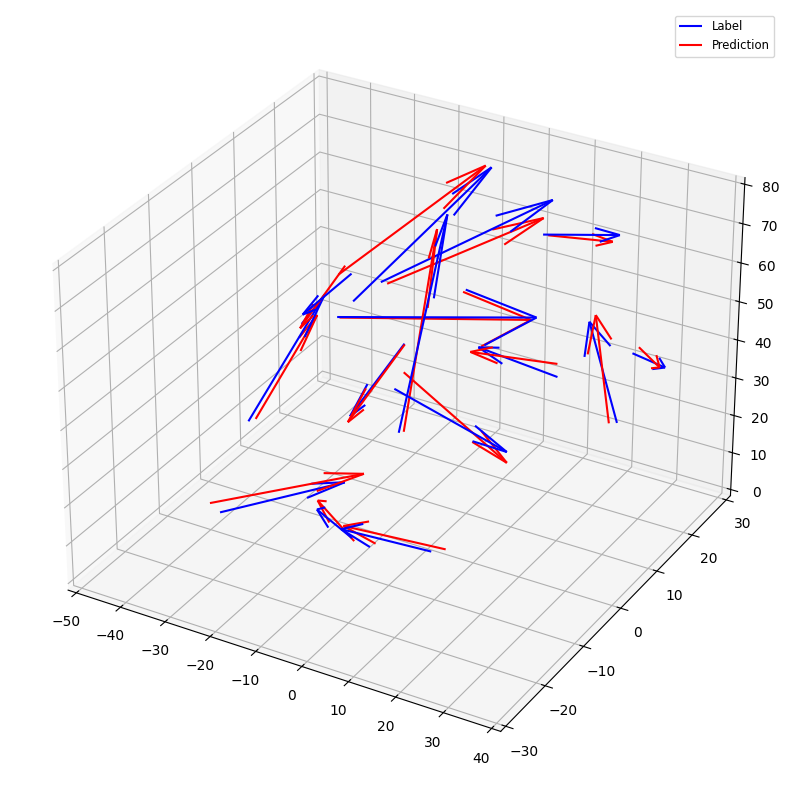

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
model2 = OurModel()
model2.load_weights('./model_weights_combination_inferenced_both_FSNN_Small_2')
test_predict_scaled = model2.predict(test_data)
diff_scaled = test_predict_scaled - test_label_scaled
mae_scaled = np.mean(abs(diff_scaled))

test_predict = scaler.inverse_transform(test_predict_scaled)
diff = test_predict - test_label_scaled
mae_f = np.mean(abs(diff))

test_predict_speed = test_predict[:,3:] - test_predict[:,:3]
test_label_speed = test_label[:,3:] - test_label[:,:3]
diff_speed= test_predict_speed - test_label_speed
mae_speed = np.mean(abs(diff_speed))

print(mae_scaled, mae_f, mae_speed)

import matplotlib.pyplot as plt
N = 40
M= 55
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-50, 40)
ax.set_ylim3d(-30, 30)
ax.set_zlim3d(0, 80)

for i in range(N,M):
    ax.quiver(test_data_original_position[i][0],test_data_original_position[i][1],test_data_original_position[i][2], 
              test_label_speed[i][0], test_label_speed[i][1], test_label_speed[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict[i][0],test_predict[i][1],test_predict[i][2], 
              test_predict_speed[i][0], test_predict_speed[i][1], test_predict_speed[i][2], 
              length=1.0,
              color='r',
              label='Prediction')
plt.legend(["Label", "Prediction"], fontsize="small")
plt.show()

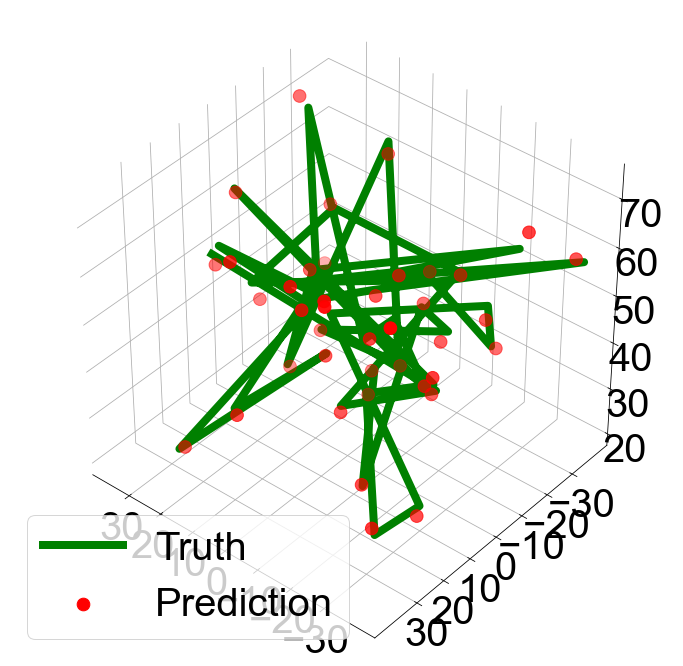

In [17]:
N=40
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
Test_4_Position = np.zeros((N,3))
Test_4_Position_speed = np.zeros((N,3))
Test_4_Predict = np.zeros((N,3))
Test_4_Predict_speed = np.zeros((N,3))
for i in range(N):
    Test_4_Position[i] = np.array([test_data_original_position[i][0],test_data_original_position[i][1],test_data_original_position[i][2]])
    Test_4_Position_speed[i] = np.array([test_label_speed[i][0], test_label_speed[i][1], test_label_speed[i][2]])
    Test_4_Predict[i] = np.array([test_predict[i][0],test_predict[i][1],test_predict[i][2]])
    Test_4_Predict_speed[i] = np.array([test_predict_speed[i][0], test_predict_speed[i][1], test_predict_speed[i][2]])
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-30, 30.1, 10), fontsize = 40)
plt.yticks(np.arange(-30, 30.1, 10), fontsize = 40)
ax.set_zticks(np.arange(20, 70.1, 10))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
#plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
#fig.draw(fig.canvas.get_renderer())
plt.show()

xwhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,0], (N, 1))
ywhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,1], (N, 1))
twhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,2], (N, 1))
Array1 = np.concatenate((xwhole,ywhole,twhole), axis = 1)

xwhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,0], (N, 1))
ywhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,1], (N, 1))
twhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,2], (N, 1))
Array2 = np.concatenate((xwhole1,ywhole1,twhole1), axis = 1)

np.savetxt("./P_Truth_01_eight.txt", Array1)
np.savetxt("./P_Predic_01_eight.txt", Array2)

0.015560410860730123 28.82578276751999 1.4606436347756804


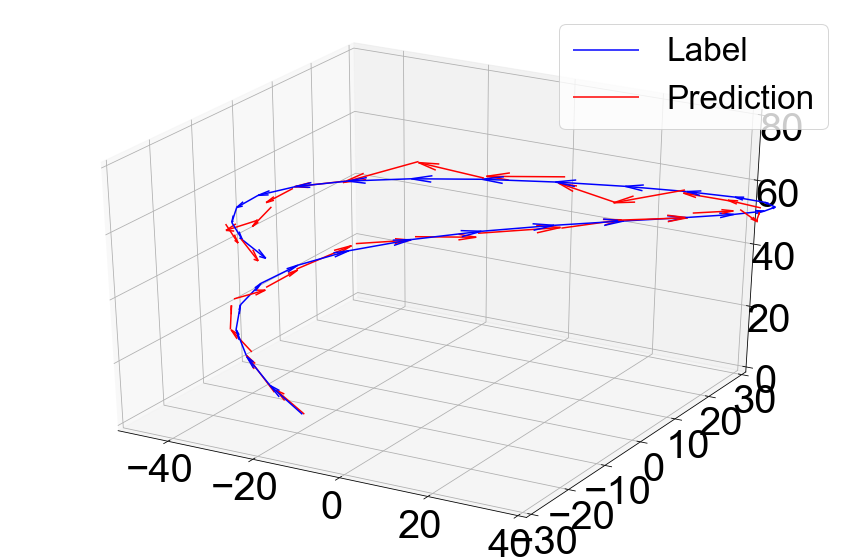

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
model2 = OurModel()
model2.load_weights('./model_weights_combination_inferenced_both_FSNN_09052023_2')
test_predict_scaled = model2.predict(test_data2)
diff_scaled = test_predict_scaled - test_label_scaled2
mae_scaled = np.mean(abs(diff_scaled))

test_predict = scaler.inverse_transform(test_predict_scaled)
diff = test_predict - test_label_scaled2
mae_f = np.mean(abs(diff))

test_predict_speed = test_predict[:,3:] - test_predict[:,:3]
test_label_speed = test_label2[:,3:] - test_label2[:,:3]
diff_speed= test_predict_speed - test_label_speed
mae_speed = np.mean(abs(diff_speed))

print(mae_scaled, mae_f, mae_speed)

import matplotlib.pyplot as plt
N = 0
M= 29
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-50, 40)
ax.set_ylim3d(-30, 30)
ax.set_zlim3d(0, 80)

for i in range(N,M):
    ax.quiver(test_data_original_position2[i][0],test_data_original_position2[i][1],test_data_original_position2[i][2], 
              test_label_speed[i][0], test_label_speed[i][1], test_label_speed[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict[i][0],test_predict[i][1],test_predict[i][2], 
              test_predict_speed[i][0], test_predict_speed[i][1], test_predict_speed[i][2], 
              length=1.0,
              color='r',
              label='Prediction')
plt.legend(["Label", "Prediction"], fontsize="small")
plt.show()

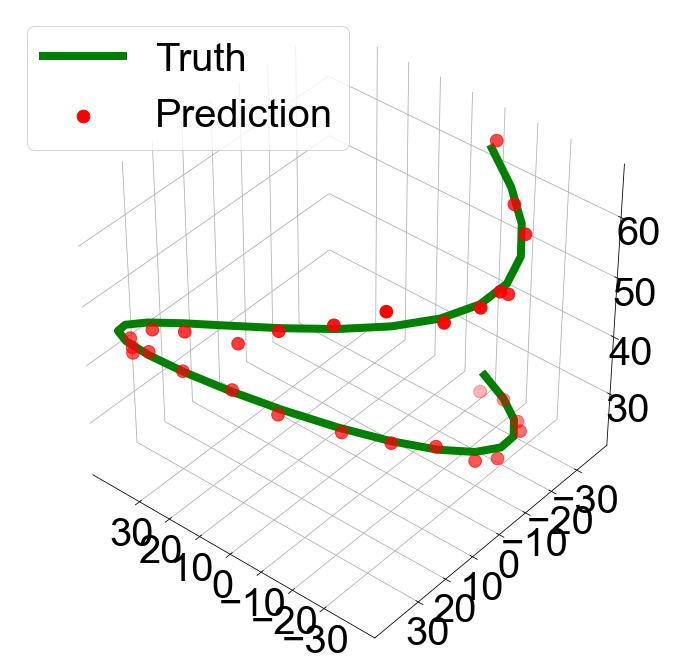

In [50]:
N=29
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
Test_4_Position = np.zeros((N,3))
Test_4_Position_speed = np.zeros((N,3))
Test_4_Predict = np.zeros((N,3))
Test_4_Predict_speed = np.zeros((N,3))
for i in range(N):
    Test_4_Position[i] = np.array([test_data_original_position2[i][0],test_data_original_position2[i][1],test_data_original_position2[i][2]])
    Test_4_Position_speed[i] = np.array([test_label_speed[i][0], test_label_speed[i][1], test_label_speed[i][2]])
    Test_4_Predict[i] = np.array([test_predict[i][0],test_predict[i][1],test_predict[i][2]])
    Test_4_Predict_speed[i] = np.array([test_predict_speed[i][0], test_predict_speed[i][1], test_predict_speed[i][2]])
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-30, 30.1, 10), fontsize = 40)
plt.yticks(np.arange(-30, 30.1, 10), fontsize = 40)
ax.set_zticks(np.arange(20, 70.1, 10))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
#plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
#fig.draw(fig.canvas.get_renderer())
plt.show()

xwhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,0], (N, 1))
ywhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,1], (N, 1))
twhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,2], (N, 1))
Array1 = np.concatenate((xwhole,ywhole,twhole), axis = 1)

xwhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,0], (N, 1))
ywhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,1], (N, 1))
twhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,2], (N, 1))
Array2 = np.concatenate((xwhole1,ywhole1,twhole1), axis = 1)

np.savetxt("./P_Truth_01_eight.txt", Array1)
np.savetxt("./P_Predic_01_eight.txt", Array2)

-39.9652824401855 39.9823150634766


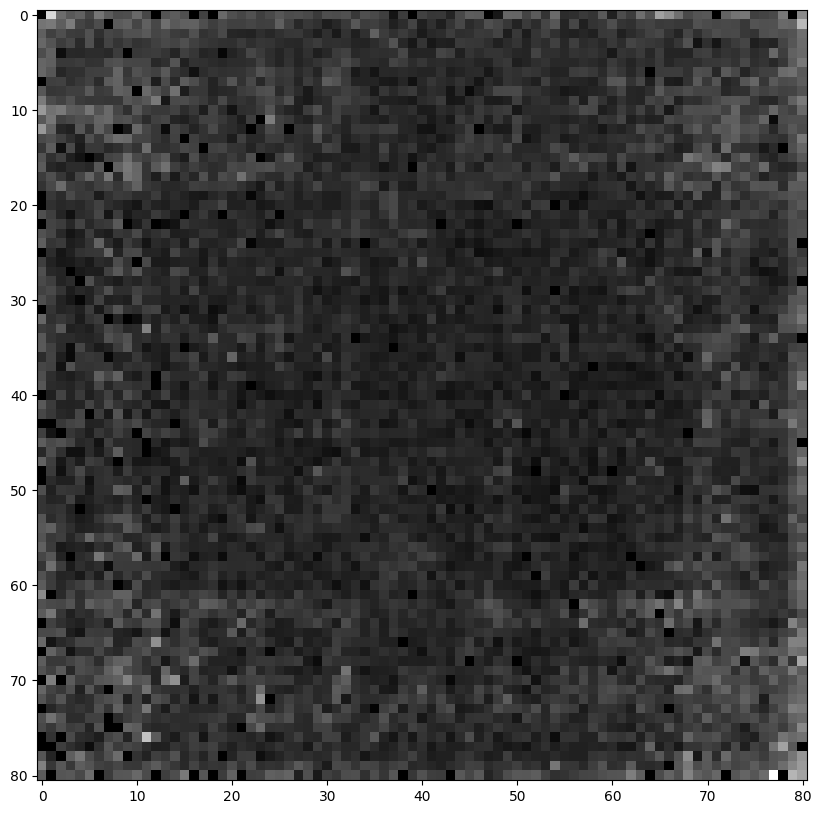

In [33]:
import math
n,dim = test_data_original_position.shape
x_ = int(round(np.max(test_data_original_position[:,0])) - round(np.min(test_data_original_position[:,0])) + 1)
y_ = int(round(np.max(test_data_original_position[:,1])) - round(np.min(test_data_original_position[:,1])) + 1)
print(np.min(test_data_original_position[:,1]),np.max(test_data_original_position[:,1]))
Array_d = np.zeros((x_,y_))
Array_n = np.zeros((x_,y_))
Array_mse = np.zeros((x_,y_))
Array_dense = np.zeros((x_,y_))
a = 0
b = 1
for i in range(n):
    x_num = int(round(test_data_original_position[i,a])-round(np.min(test_data_original_position[:,a])))
    y_num = int(round(test_data_original_position[i,b])-round(np.min(test_data_original_position[:,b])))
    '''if x_num > 70:
        print(round(test_data_original_position[i,a])-round(np.min(test_data_original_position[:,a])))
        print((test_data_original_position[i,a]-test_predict[i,a])**2)'''
    Array_n[x_num,y_num] += 1
    Array_d[x_num,y_num] += math.sqrt((test_data_original_position[i,a]-test_predict[i,a])**2 + (test_data_original_position[i,b]-test_predict[i,b])**2)
for i in range(x_):
    for j in range(y_):
        Array_mse[i,j] = Array_d[i,j]/Array_n[i,j] if Array_n[i,j] != 0 else 0
fig = plt.figure(figsize=(15,10))
plt.imshow(Array_mse, cmap = "gray")

[-24.87142754  25.13708878  32.40586472] [-36.56496811  35.71053696  23.80733871]
-39.9652824401855 39.9823150634766
-77.4522895812988 79.53033065795901
-39.9788703918457 39.9956321716309
5.703352628126051 1.4249722634197965


12.807310474688574

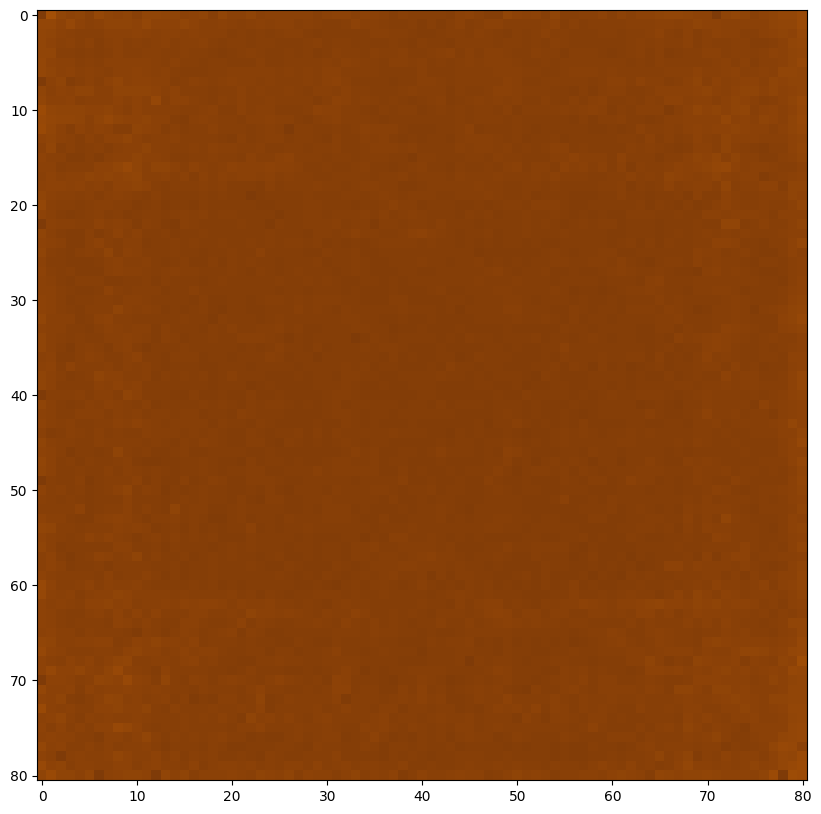

In [34]:
n,dim = test_data_original_position.shape
predicted_end_position = np.zeros((n,dim))
truth_end_position = np.zeros((n,dim))
for i in range(dim):
    truth_end_position[:,i] = test_data_original_position[:,i] + test_label_speed[:,i]
    predicted_end_position[:,i] = test_predict[:,i] + test_predict_speed[:,i]

print(truth_end_position[1,:], test_data_original_position[1,:])
                
print(np.min(test_data_original_position[:,1]),np.max(test_data_original_position[:,1]))
print(np.min(test_label_speed[:,1]),np.max(test_label_speed[:,1]))
print(np.min(truth_end_position[:,1]),np.max(truth_end_position[:,1]))
x_ = int(round(np.max(truth_end_position[:,0])) - round(np.min(truth_end_position[:,0])) + 1)
y_ = int(round(np.max(truth_end_position[:,1])) - round(np.min(truth_end_position[:,1])) + 1)
a = 0
b = 1
for i in range(n):
    x_num = int(round(truth_end_position[i,a])-round(np.min(truth_end_position[:,a])))
    y_num = int(round(truth_end_position[i,b])-round(np.min(truth_end_position[:,b])))
    '''if x_num > 70:
        print(round(test_data_original_position[i,a])-round(np.min(test_data_original_position[:,a])))
        print((test_data_original_position[i,a]-test_predict[i,a])**2)'''
    Array_n[x_num,y_num] += 1
    Array_d[x_num,y_num] += math.sqrt((truth_end_position[i,a]-predicted_end_position[i,a])**2 + (truth_end_position[i,b]-predicted_end_position[i,b])**2)
for i in range(x_):
    for j in range(y_):
        Array_mse[i,j] = Array_d[i,j]/Array_n[i,j] if Array_n[i,j] != 0 else 0
fig = plt.figure(figsize=(15,10))
plt.imshow(Array_mse, cmap = "PuOr")
plt.clim(0,80)
print(np.max(Array_mse), np.mean(Array_mse))
np.mean(Array_d)

(81, 81)


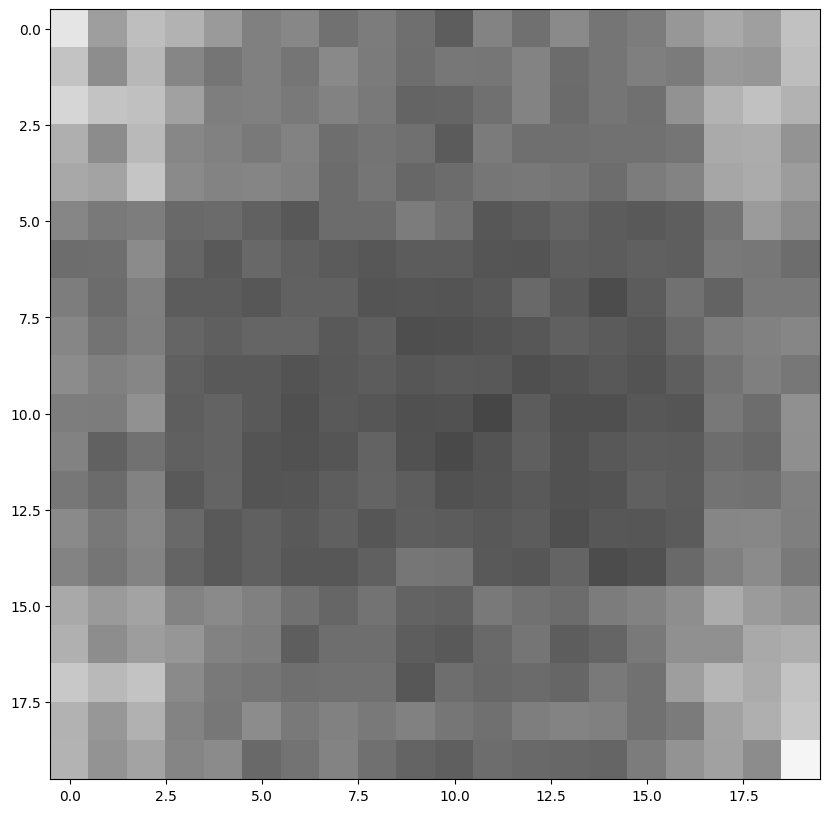

In [18]:
print(Array_mse.shape)
def ar_compressed(Array_1,Array_2, x_0, y_0):
    x, y = Array_1.shape
    x_1 , y_1 = int(np.floor(x/x_0)), int(np.floor(y/y_0))
    Array_temp = np.zeros((x_1, y_1))
    Array_temp_n = np.zeros((x_1, y_1))
    for i in range(x_1):
        for j in range(y_1):
            for k in range(x_0):
                for m in range(y_0):
                    try:
                        Array_temp[i,j] += Array_1[k+i*x_0,m+j*y_0]
                        Array_temp_n[i,j] += Array_2[k+i*x_0,m+j*y_0]
                    except IndexError:
                        break
    return Array_temp, Array_temp_n
fig = plt.figure(figsize=(15,10))
Array_comp,Array_comp_n = ar_compressed(Array_d,Array_n,4,4)

x_, y_ = Array_comp.shape
Array_mse = np.zeros((x_,y_))
for i in range(x_):
    for j in range(y_):
        Array_mse[i,j] = Array_comp[i,j]/Array_comp_n[i,j] if Array_comp[i,j] != 0 else 0
plt.imshow(Array_mse, cmap = "gray")
np.savetxt("./FOV_stereo_xy.txt", Array_mse)
plt.clim(0,3)
    

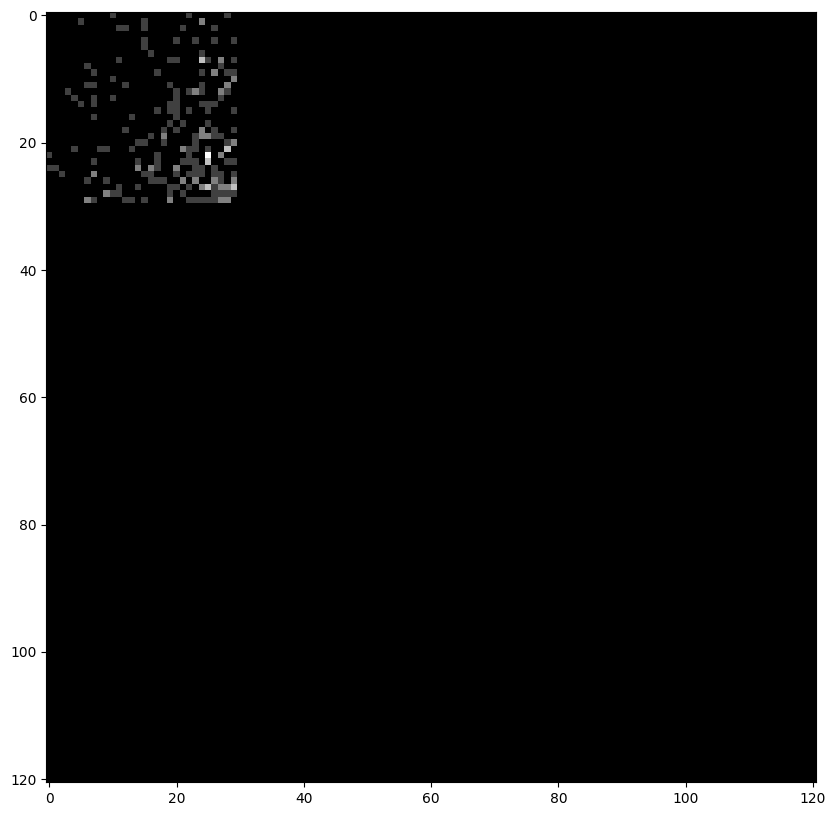

In [6]:
for i in range(x_):
    for j in range(y_):
        Array_dense[i,j] = Array_n[i,j]/n
fig = plt.figure(figsize=(15,10))
plt.imshow(Array_dense, cmap = "gray")

(81, 56) 39.989501953125


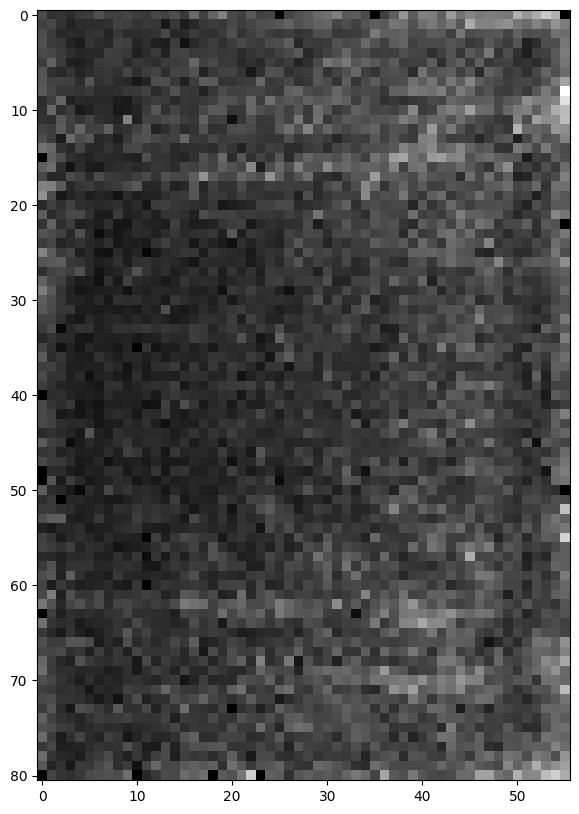

In [19]:
import math
a = 0
b = 2
n,dim = test_data_original_position.shape
x_ = int(round(np.max(test_data_original_position[:,a])) - round(np.min(test_data_original_position[:,a])) + 1)
y_ = int(round(np.max(test_data_original_position[:,b])) - round(np.min(test_data_original_position[:,b])) + 1)
Array_d = np.zeros((x_,y_))
Array_n = np.zeros((x_,y_))
Array_mse = np.zeros((x_,y_))
for i in range(n):
    x_num = int(round(test_data_original_position[i,a])-round(np.min(test_data_original_position[:,a])))
    y_num = int(round(test_data_original_position[i,b])-round(np.min(test_data_original_position[:,b])))
    Array_n[x_num,y_num] += 1
    Array_d[x_num,y_num] += math.sqrt((test_data_original_position[i,a]-test_predict[i,a])**2 + (test_data_original_position[i,b]-test_predict[i,b])**2)
for i in range(x_):
    for j in range(y_):
        Array_mse[i,j] = Array_d[i,j]/Array_n[i,j] if Array_n[i,j] != 0 else 0
print(Array_d.shape, np.max(test_data_original_position[:,0]))
fig = plt.figure(figsize=(15,10))
plt.imshow(Array_mse, cmap = "gray")

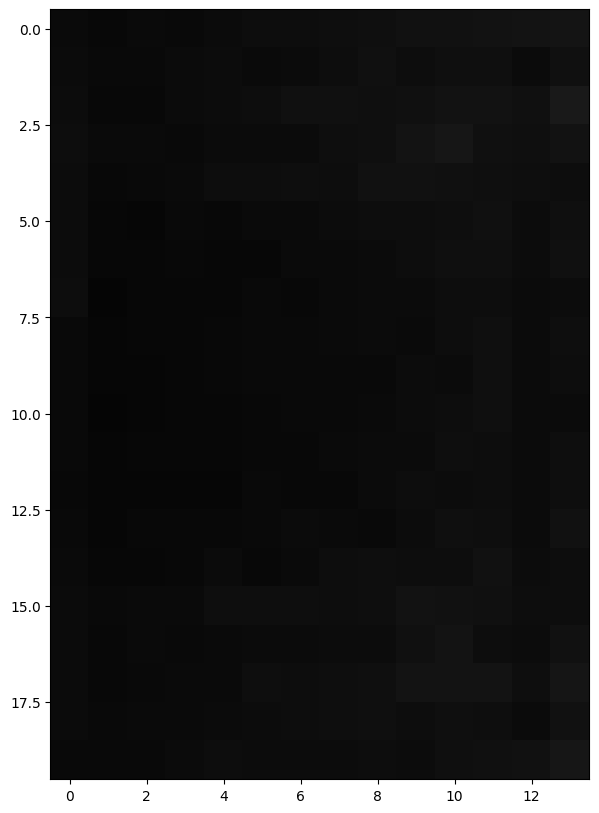

In [20]:
fig = plt.figure(figsize=(15,10))
Array_comp,Array_comp_n = ar_compressed(Array_d,Array_n,4,4)
x_, y_ = Array_comp.shape
Array_mse = np.zeros((x_,y_))
for i in range(x_):
    for j in range(y_):
        Array_mse[i,j] = Array_comp[i,j]/Array_comp_n[i,j] if Array_comp[i,j] != 0 else 0

plt.imshow(Array_mse, cmap = "gray")
np.savetxt("./FOV_stereo_xz.txt", Array_mse)
plt.clim(0,40)

In [12]:
import os
from os import walk

def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".txt"):
                data = np.genfromtxt(root+'/'+file)
                (row,) = data.shape
                col = 1
                count += 1
            elif count != 0 and file.endswith(".txt"):
                data1 = np.genfromtxt(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = data.reshape((count, row, col))
    return data, count
Data2, c12 = dataload('C:/Data/09012023_8')
test_data4, test_data_original_position4, test_data_final_position4, test_label4 = data_preprocessing(Data2)


6.0


In [39]:
np.savetxt('test_8.txt',test_data4.reshape(-1,64), delimiter = ',')
np.savetxt('test_labels.txt',test_label4, delimiter = ',')

2/2 [==============================] - 0s 1ms/step
[  0.5492142    0.21847214  42.820545   -12.633563    -5.2993546
  47.315563  ] [ 4.43531989e-15 -1.12985214e-02  4.49811821e+01]
[-12.998587   -5.603155   47.443356  -23.357412   -7.2068686  48.237797 ] [-12.34811211  -3.68217826  47.33094406]
[-22.336407   -6.5921206  48.5191    -33.667553  -11.523173   52.325974 ] [-23.49827385  -7.81404781  49.66392136]
[-33.237118 -11.027757  52.178738 -37.46288  -18.682396  54.42703 ] [-32.35094452 -12.29230881  51.99743652]
[-37.06956  -19.253962  54.716835 -38.03469  -21.96833   55.291565] [-38.03567123 -17.0051403   54.33062744]
[-37.62695  -21.954643  55.2843   -37.896393 -27.657663  61.676517] [-39.99749374 -21.83679008  56.66369247]
[-37.764923 -27.090317  62.752224 -33.905727 -33.797344  64.755554] [-38.04439926 -26.67002487  58.99744797]
[-33.444786 -33.202484  66.143776 -23.994297 -35.30328   65.93748 ] [-32.3670578  -31.3833847   61.33070755]
[-23.406227 -35.213604  65.677414 -13.314184

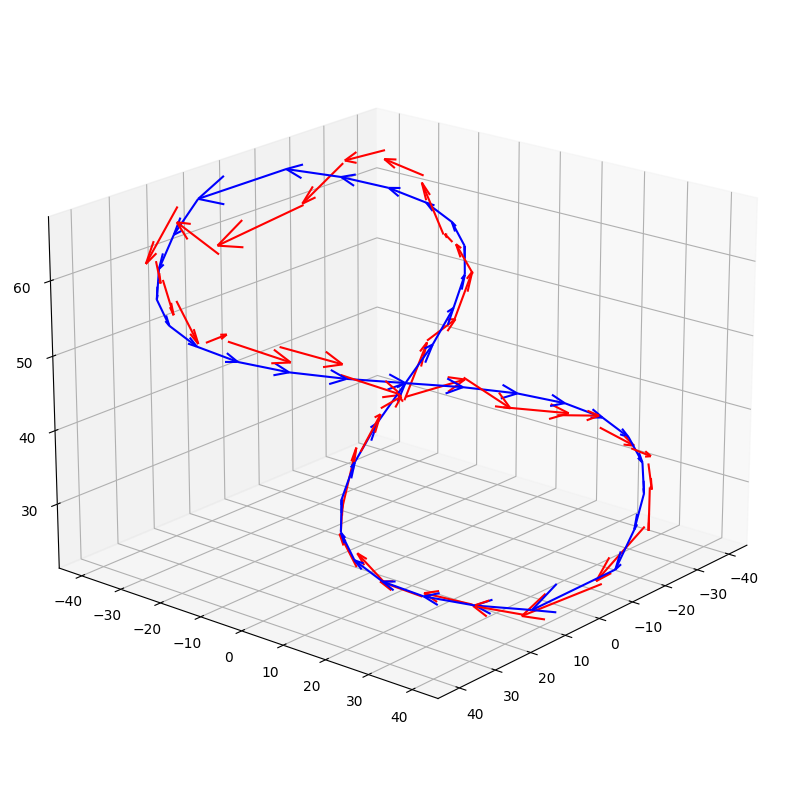

In [13]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

test_label_scaled4 = scaler.transform(test_label4)
pred2 = model2.predict(test_data4)
diff_scaled4 = pred2 - test_label_scaled4
mae_scaled4 = np.mean(abs(diff_scaled4))

test_predict4 = scaler.inverse_transform(pred2)
diff4 = test_predict4 - test_label_scaled4
mae_f4 = np.mean(abs(diff4))

test_predict_speed4 = test_predict4[:,3:] - test_predict4[:,:3]
test_label_speed4 = test_label4[:,3:] - test_label4[:,:3]
diff_speed4= test_predict_speed4 - test_label_speed4
mae_speed4 = np.mean(abs(diff_speed4))

for i in range(10):
    print(test_predict4[i] ,test_data_original_position4[i])
    N = test_predict4.shape[0]
    
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.view_init(20, 40)
#ax.set_xlim3d(-20, 20)
#ax.set_ylim3d(-20, 20)
#ax.set_zlim3d(10, 80)
for i in range(N):
    ax.quiver(test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2], 
              test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict4[i][0],test_predict4[i][1],test_predict4[i][2], 
              test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2], 
              length=1.0,
              color='r',
              label='Prediction')
plt.show()

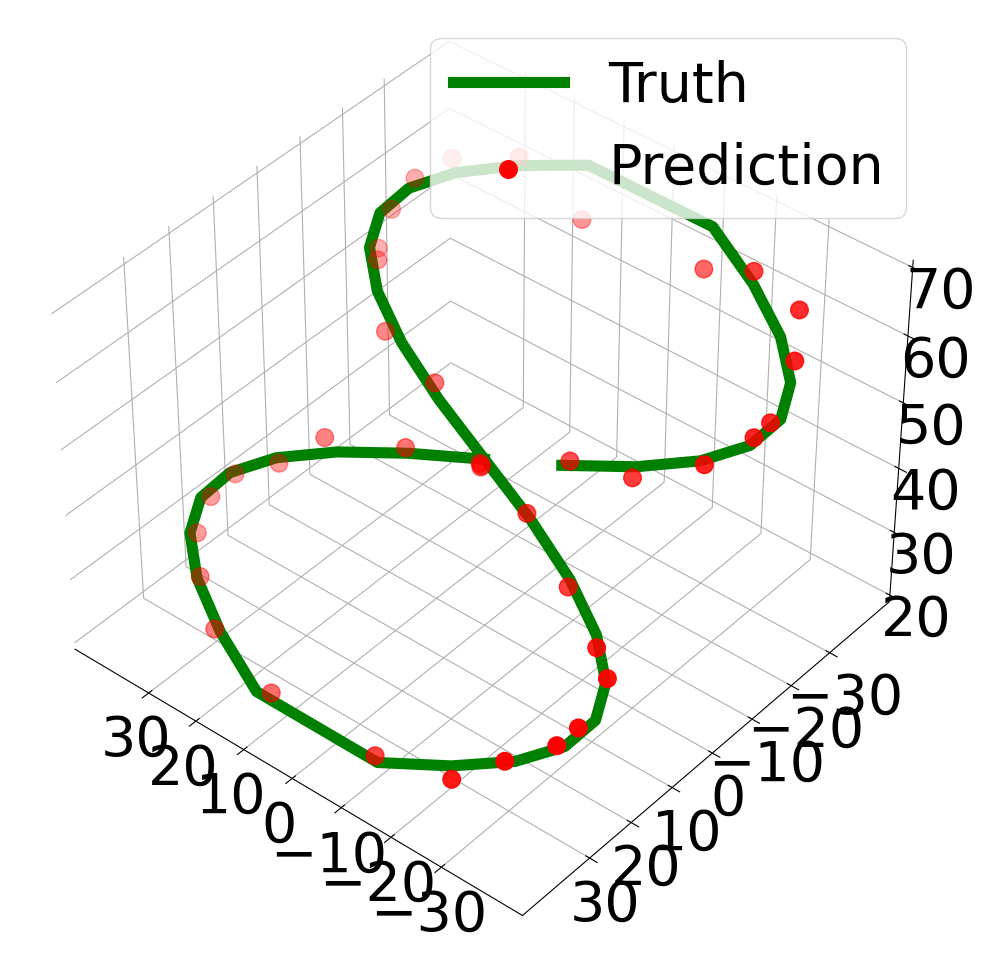

In [14]:
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
Test_4_Position = np.zeros((N,3))
Test_4_Position_speed = np.zeros((N,3))
Test_4_Predict = np.zeros((N,3))
Test_4_Predict_speed = np.zeros((N,3))
for i in range(N):
    Test_4_Position[i] = np.array([test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2]])
    Test_4_Position_speed[i] = np.array([test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2]])
    Test_4_Predict[i] = np.array([test_predict4[i][0],test_predict4[i][1],test_predict4[i][2]])
    Test_4_Predict_speed[i] = np.array([test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2]])
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-30, 30.1, 10), fontsize = 40)
plt.yticks(np.arange(-30, 30.1, 10), fontsize = 40)
ax.set_zticks(np.arange(20, 70.1, 10))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
#plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
#fig.draw(fig.canvas.get_renderer())
plt.show()

xwhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,0], (N, 1))
ywhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,1], (N, 1))
twhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,2], (N, 1))
Array1 = np.concatenate((xwhole,ywhole,twhole), axis = 1)

xwhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,0], (N, 1))
ywhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,1], (N, 1))
twhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,2], (N, 1))
Array2 = np.concatenate((xwhole1,ywhole1,twhole1), axis = 1)

np.savetxt("./P_Truth_01_eight_0908.txt", Array1)
np.savetxt("./P_Predic_01_eight_0908.txt", Array2)

In [21]:
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-30, 30.1, 10), fontsize = 40)
plt.yticks(np.arange(-30, 30.1, 10), fontsize = 40)
ax.set_zticks(np.arange(20, 70.1, 10))
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
fig.draw(fig.canvas.get_renderer())
plt.show()

NameError: name 'Test_4_Position' is not defined

<Figure size 1200x1200 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-30, 30.1, 10), fontsize = 40)
plt.yticks(np.arange(-30, 30.1, 10), fontsize = 40)
ax.set_zticks(np.arange(20, 70.1, 10))
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
fig.draw(fig.canvas.get_renderer())
plt.show()
for i in range(200):
    fig = plt.figure(figsize = (12,12))
    # ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)
    ax.plot((Test_4_Position+Test_4_Position_speed)[:i,0],(Test_4_Position+Test_4_Position_speed)[:i,1],(Test_4_Position+Test_4_Position_speed)[:i,2]
            ,c='g', label= 'Truth', linewidth = 8)
    ax.plot((Test_4_Predict+Test_4_Predict_speed)[:i,0],(Test_4_Predict+Test_4_Predict_speed)[:i,1],(Test_4_Predict+Test_4_Predict_speed)[:i,2]
            ,c='r', linewidth = 4, label='Prediction')
    plt.legend(fontsize=40)
    plt.xticks(np.arange(-30, 30.1, 10), fontsize = 40)
    plt.yticks(np.arange(-30, 30.1, 10), fontsize = 40)
    ax.set_zticks(np.arange(20, 70.1, 10))
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    plt.axis([-30, 30, -30, 30])
    ax.set_zlim(20, 70)
    ax.zaxis.pane.set_edgecolor('w')
    ax.tick_params(axis='z', labelsize= 40)
    ax.view_init(40, 130)
    fig.draw(fig.canvas.get_renderer())
    plt.savefig('./Graph_eight_line/Fig'+str(i)+'.png')
plt.show()

In [14]:
import os
from os import walk

def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".txt"):
                data = np.genfromtxt(root+'/'+file)
                (row,) = data.shape
                col = 1
                count += 1
            elif count != 0 and file.endswith(".txt"):
                data1 = np.genfromtxt(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = data.reshape((count, row, col))
    return data, count
Data2, c12 = dataload('C:/Data/09012023_1')
test_data4, test_data_original_position4, test_data_final_position4, test_label4 = data_preprocessing(Data2)


6.0


[ -4.452821     0.09625697  35.821877   -24.42799    -23.000423
  21.242306  ] [3.37048164e-06 3.37048164e-06 4.00000076e+01]
[-24.236511 -22.16457   20.407452 -20.455975 -17.972187  24.09509 ] [-29.96802139 -29.96802139  27.50266457]
[-23.089754 -18.801088  22.293037 -18.300444 -17.165537  28.503302] [-25.00611115 -25.00611115  31.24538994]
[-20.302507 -15.927602  29.045008 -10.557309 -13.23404   29.071392] [-20.00617409 -20.00617409  34.99536896]
[-13.781462  -10.524679   31.371962   -5.9795704  -8.346229   28.822285 ] [-15.00527954 -15.00527954  38.74603653]
[-7.921976  -7.85466   33.940315  -0.990502  -4.8376923 32.88978  ] [-10.0067482 -10.0067482  42.4949379]
[-2.2336507 -2.076453  42.227734   2.9331791 -3.5068362 36.693027 ] [-5.00634336 -5.00634336 46.24524307]
[ 0.18387535 -0.43028134 47.894444    6.805413   -0.29106554 41.999107  ] [-6.41143229e-03 -6.41143229e-03  4.99951935e+01]
[ 4.0699277  5.7516847 47.51842    8.5752325  6.11632   48.222645 ] [ 4.99348307  4.99348307 53.

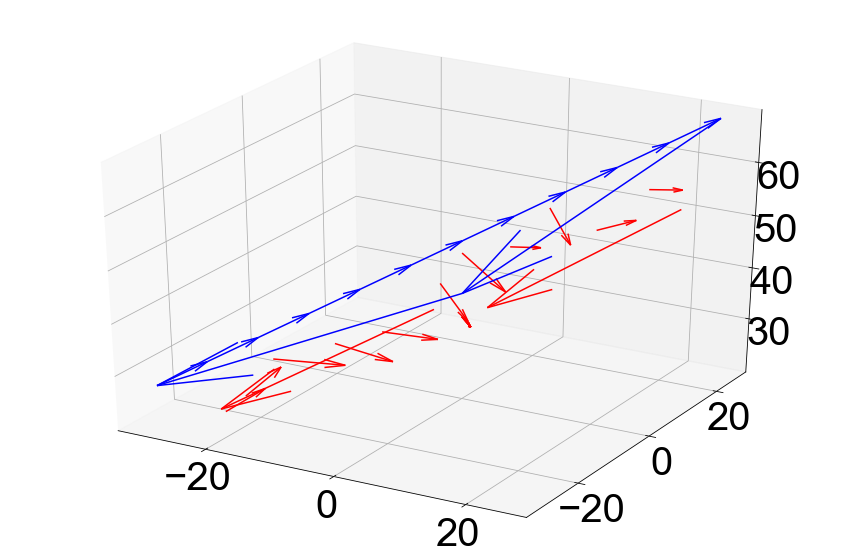

In [15]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

test_label_scaled4 = scaler.transform(test_label4)
pred2 = model2.predict(test_data4)
diff_scaled4 = pred2 - test_label_scaled4
mae_scaled4 = np.mean(abs(diff_scaled4))

test_predict4 = scaler.inverse_transform(pred2)
diff4 = test_predict4 - test_label_scaled4
mae_f4 = np.mean(abs(diff4))

test_predict_speed4 = test_predict4[:,3:] - test_predict4[:,:3]
test_label_speed4 = test_label4[:,3:] - test_label4[:,:3]
diff_speed4= test_predict_speed4 - test_label_speed4
mae_speed4 = np.mean(abs(diff_speed4))

for i in range(10):
    print(test_predict4[i] ,test_data_original_position4[i])
    N = test_predict4.shape[0]
    
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
#ax.set_xlim3d(-20, 20)
#ax.set_ylim3d(-20, 20)
#ax.set_zlim3d(10, 80)
for i in range(N):
    ax.quiver(test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2], 
              test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict4[i][0],test_predict4[i][1],test_predict4[i][2], 
              test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2], 
              length=1.0,
              color='r',
              label='Prediction')
plt.show()

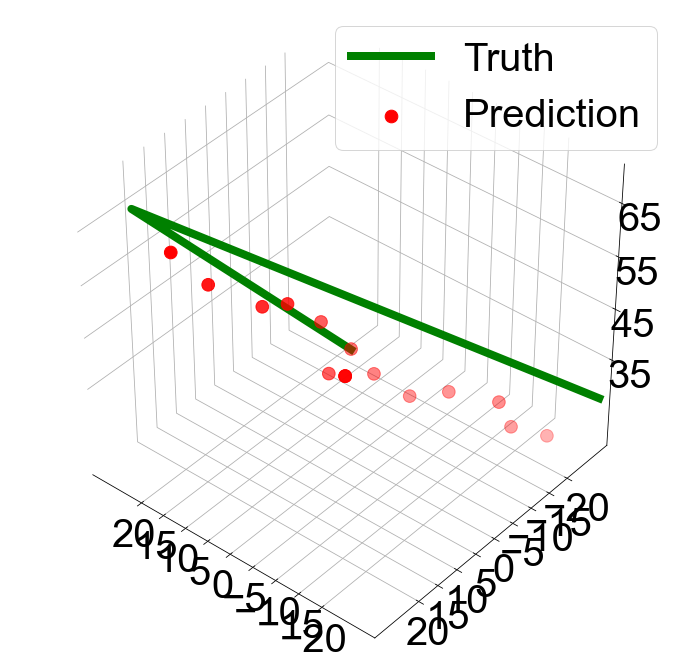

In [16]:
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
Test_4_Position = np.zeros((N,3))
Test_4_Position_speed = np.zeros((N,3))
Test_4_Predict = np.zeros((N,3))
Test_4_Predict_speed = np.zeros((N,3))
for i in range(N):
    Test_4_Position[i] = np.array([test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2]])
    Test_4_Position_speed[i] = np.array([test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2]])
    Test_4_Predict[i] = np.array([test_predict4[i][0],test_predict4[i][1],test_predict4[i][2]])
    Test_4_Predict_speed[i] = np.array([test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2]])
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-20, 20.1, 5), fontsize = 40)
plt.yticks(np.arange(-20, 20.1, 5), fontsize = 40)
ax.set_zticks(np.arange(35, 70.1, 10))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
fig.draw(fig.canvas.get_renderer())
plt.savefig('C:/Users/qoqud/Graph_12345.png')
plt.show()

xwhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,0], (N, 1))
ywhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,1], (N, 1))
twhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,2], (N, 1))
Array1 = np.concatenate((xwhole,ywhole,twhole), axis = 1)

xwhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,0], (N, 1))
ywhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,1], (N, 1))
twhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,2], (N, 1))
Array2 = np.concatenate((xwhole1,ywhole1,twhole1), axis = 1)

np.savetxt("./P_Truth_02_line.txt", Array1)
np.savetxt("./P_Predic_02_line.txt", Array2)

In [15]:
import os
from os import walk

def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".txt"):
                data = np.genfromtxt(root+'/'+file)
                (row,) = data.shape
                col = 1
                count += 1
            elif count != 0 and file.endswith(".txt"):
                data1 = np.genfromtxt(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = data.reshape((count, row, col))
    return data, count
Data2, c12 = dataload('C:/Data/09012023_s')
test_data4, test_data_original_position4, test_data_final_position4, test_label4 = data_preprocessing(Data2)


6.0


1/1 [==============================] - 0s 32ms/step
[ -0.46471393 -37.72303     21.933252    -9.31485    -36.5491
  25.871986  ] [-8.87140720e-15 -3.99532661e+01  2.50058403e+01]
[-11.238907 -36.207993  24.755621 -24.579277 -28.049713  28.345041] [-12.34765625 -34.41408539  26.37786293]
[-23.731379 -27.455647  28.846037 -33.027233 -23.056284  28.592476] [-23.49810982 -28.1457119   27.75697517]
[-33.366287 -21.301743  29.394249 -38.0523   -16.240795  32.36497 ] [-32.349617   -21.35284424  29.13620949]
[-38.0291    -16.833437   31.209045  -38.54759    -5.7528677  29.437965 ] [-38.03624344 -14.20145893  30.5157795 ]
[-38.527283   -5.7906685  28.570263  -37.889915    1.0442929  32.23837  ] [-39.99761963  -6.87181234  31.89487648]
[-37.469788     0.85130686  31.16161    -32.63866      9.622679
  36.928753  ] [-38.04433823   0.46026513  33.2743988 ]
[-31.478598   9.124904  35.495037 -24.500969  14.6385    35.414223] [-32.36717224   7.61034727  34.65359497]
[-24.292051  15.654345  35.649334 -

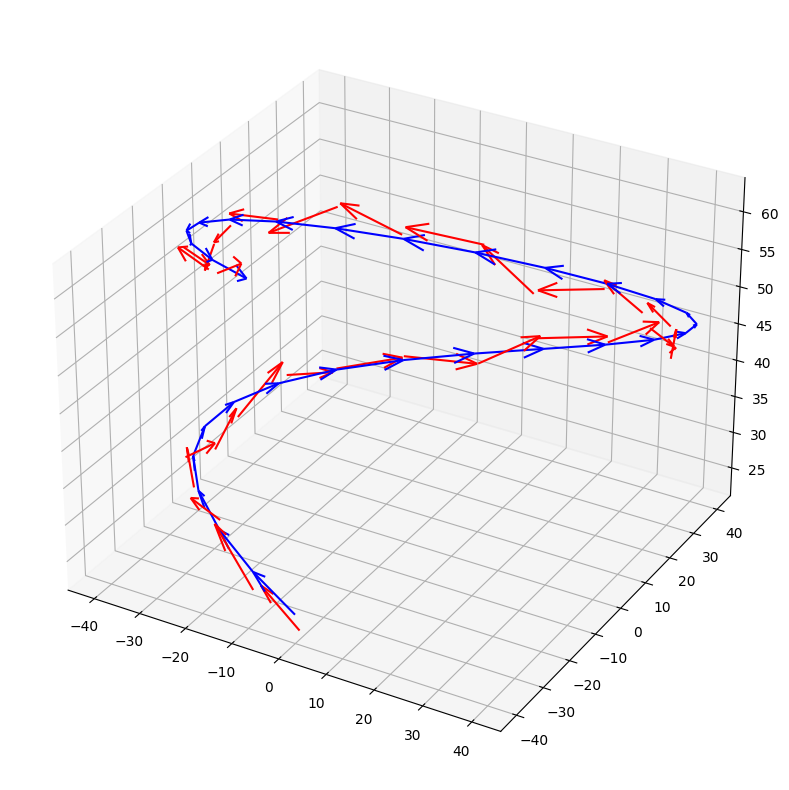

In [16]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

test_label_scaled4 = scaler.transform(test_label4)
pred2 = model2.predict(test_data4)
diff_scaled4 = pred2 - test_label_scaled4
mae_scaled4 = np.mean(abs(diff_scaled4))

test_predict4 = scaler.inverse_transform(pred2)
diff4 = test_predict4 - test_label_scaled4
mae_f4 = np.mean(abs(diff4))

test_predict_speed4 = test_predict4[:,3:] - test_predict4[:,:3]
test_label_speed4 = test_label4[:,3:] - test_label4[:,:3]
diff_speed4= test_predict_speed4 - test_label_speed4
mae_speed4 = np.mean(abs(diff_speed4))

for i in range(20):
    print(test_predict4[i] ,test_data_original_position4[i])
    N = test_predict4.shape[0]
    
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
#ax.set_xlim3d(-20, 20)
#ax.set_ylim3d(-20, 20)
#ax.set_zlim3d(10, 80)
for i in range(N):
    ax.quiver(test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2], 
              test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict4[i][0],test_predict4[i][1],test_predict4[i][2], 
              test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2], 
              length=1.0,
              color='r',
              label='Prediction')
plt.show()

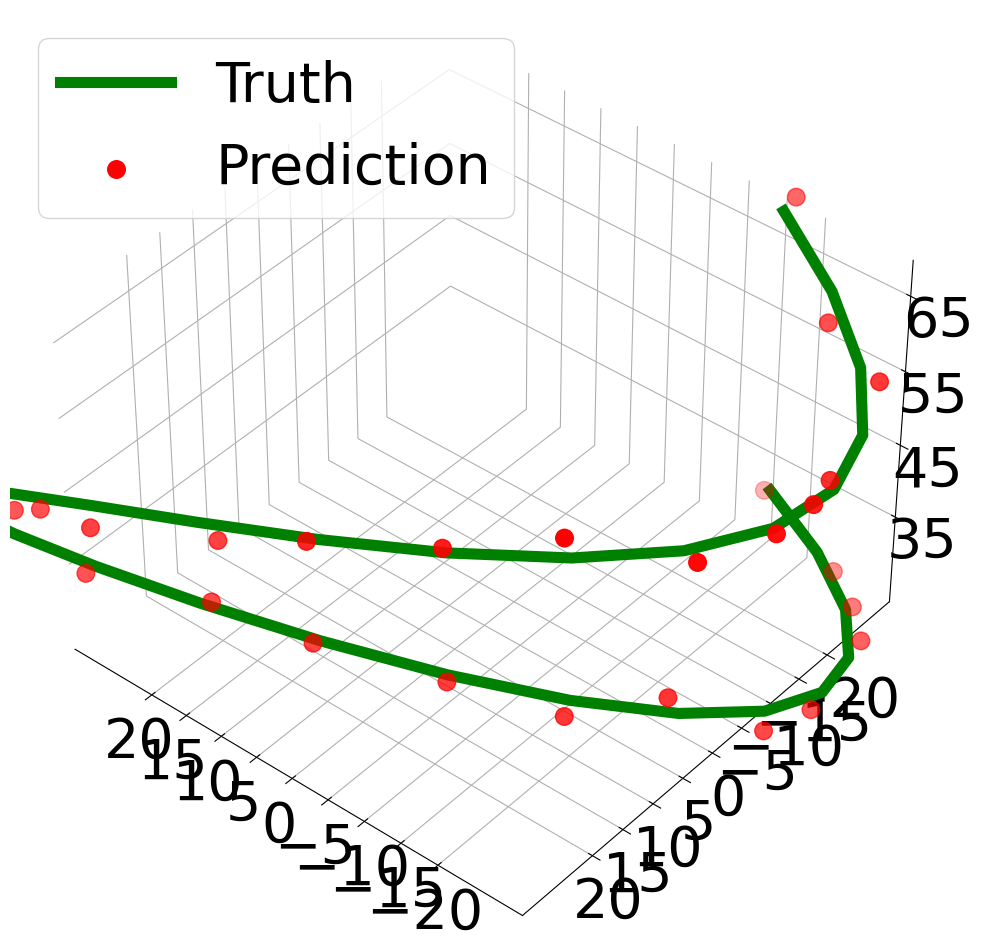

In [37]:
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
Test_4_Position = np.zeros((N,3))
Test_4_Position_speed = np.zeros((N,3))
Test_4_Predict = np.zeros((N,3))
Test_4_Predict_speed = np.zeros((N,3))
for i in range(N):
    Test_4_Position[i] = np.array([test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2]])
    Test_4_Position_speed[i] = np.array([test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2]])
    Test_4_Predict[i] = np.array([test_predict4[i][0],test_predict4[i][1],test_predict4[i][2]])
    Test_4_Predict_speed[i] = np.array([test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2]])
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-20, 20.1, 5), fontsize = 40)
plt.yticks(np.arange(-20, 20.1, 5), fontsize = 40)
ax.set_zticks(np.arange(35, 70.1, 10))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
fig.draw(fig.canvas.get_renderer())
plt.savefig('C:/Users/qoqud/Graph_12345.png')
plt.show()

xwhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,0], (N, 1))
ywhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,1], (N, 1))
twhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,2], (N, 1))
Array1 = np.concatenate((xwhole,ywhole,twhole), axis = 1)

xwhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,0], (N, 1))
ywhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,1], (N, 1))
twhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,2], (N, 1))
Array2 = np.concatenate((xwhole1,ywhole1,twhole1), axis = 1)

np.savetxt("./P_Truth_03_U.txt", Array1)
np.savetxt("./P_Predic_03_U.txt", Array2)

In [17]:
import os
from os import walk

def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".txt"):
                data = np.genfromtxt(root+'/'+file)
                (row,) = data.shape
                col = 1
                count += 1
            elif count != 0 and file.endswith(".txt"):
                data1 = np.genfromtxt(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = data.reshape((count, row, col))
    return data, count
Data2, c12 = dataload('C:/Data/02242023_04_en')
test_data4, test_data_original_position4, test_data_final_position4, test_label4 = data_preprocessing(Data2)


[-0.6735226  -0.39546746 29.624258   -0.91925496  0.22320291 40.12631   ] [ 0.  0. 30.]
[-9.6507692e-01 -3.4891963e-02  4.1852131e+01 -1.5833215e+00
 -5.5927038e-01  3.9522835e+01] [3.32731821e-15 0.00000000e+00 3.99899368e+01]
[-1.2096035  -0.38233417 40.16072    -3.805223   -1.2763691  40.901093  ] [-1.8815136  -0.48575231 40.4076767 ]
[-3.583931  -1.5504959 41.483204  -5.480252  -1.2936779 40.54235  ] [-3.75778365 -0.98661411 40.81584167]
[-5.6270676 -1.6076784 40.981552  -7.3278728 -2.086239  40.433342 ] [-5.61944008 -1.5016048  41.22405243]
[-7.218157  -2.3280382 41.259846  -9.489588  -2.862309  41.3859   ] [-7.45879078 -2.03012371 41.63222885]
[ -8.878796  -3.283048  41.91937  -11.121169  -3.562766  42.550465] [-9.26839828 -2.57159257 42.04034042]
[-10.810543   -3.9682403  42.67807   -12.286319   -4.991704   44.830082 ] [-11.04160786  -3.12561655  42.44849014]
[-12.170521   -5.0853896  45.7414    -14.615171   -4.3632917  43.83782  ] [-12.77135277  -3.69163394  42.85666275]
[-14.6

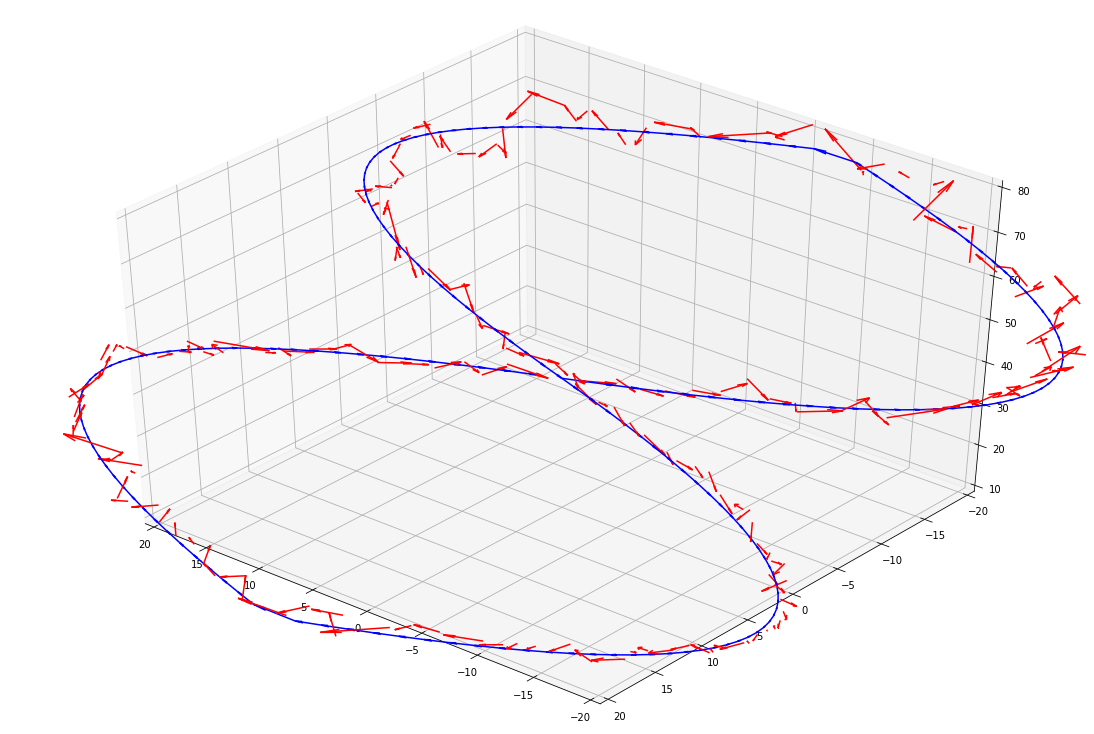

In [18]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

test_label_scaled4 = scaler.transform(test_label4)
pred2 = model2.predict(test_data4)
diff_scaled4 = pred2 - test_label_scaled4
mae_scaled4 = np.mean(abs(diff_scaled4))

test_predict4 = scaler.inverse_transform(pred2)
diff4 = test_predict4 - test_label_scaled4
mae_f4 = np.mean(abs(diff4))

test_predict_speed4 = test_predict4[:,3:] - test_predict4[:,:3]
test_label_speed4 = test_label4[:,3:] - test_label4[:,:3]
diff_speed4= test_predict_speed4 - test_label_speed4
mae_speed4 = np.mean(abs(diff_speed4))

for i in range(20):
    print(test_predict4[i] ,test_data_original_position4[i])
    N = test_predict4.shape[0]
    
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig)
ax.set_xlim3d(-20, 20)
ax.set_ylim3d(-20, 20)
ax.set_zlim3d(10, 80)
ax.view_init(40, 130)
for i in range(N)[1:]:
    ax.quiver(test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2], 
              test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict4[i][0],test_predict4[i][1],test_predict4[i][2], 
              test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2], 
              length=1.0,
              color='r',
              label='Prediction')

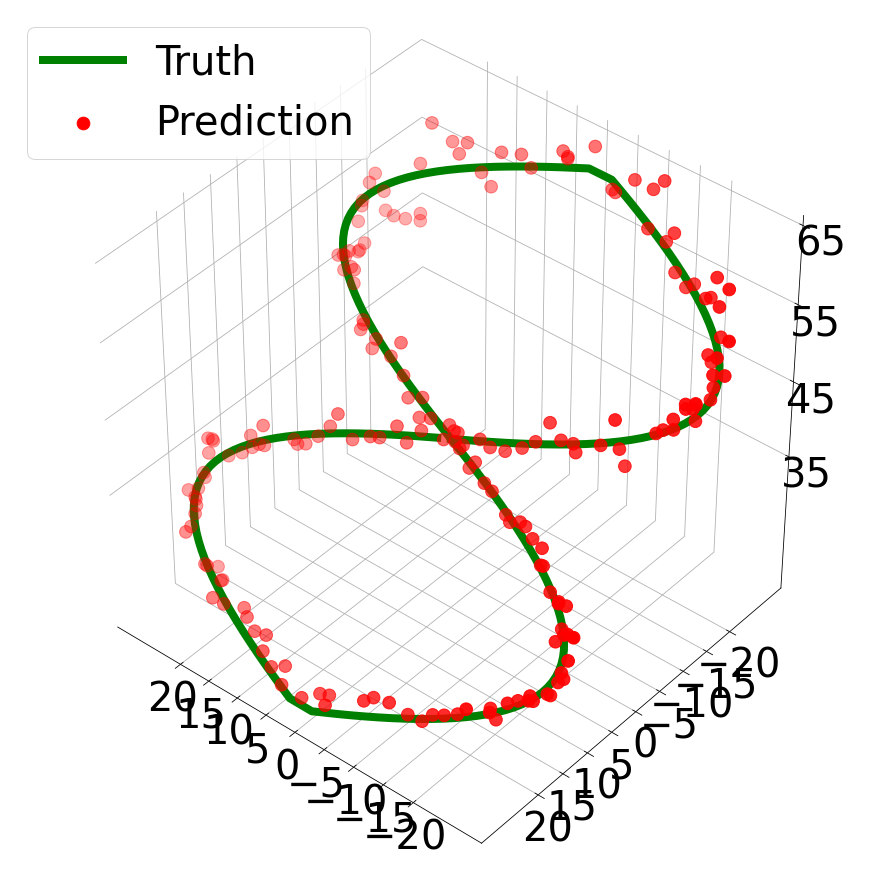

In [19]:
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
Test_4_Position = np.zeros((N,3))
Test_4_Position_speed = np.zeros((N,3))
Test_4_Predict = np.zeros((N,3))
Test_4_Predict_speed = np.zeros((N,3))
for i in range(N):
    Test_4_Position[i] = np.array([test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2]])
    Test_4_Position_speed[i] = np.array([test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2]])
    Test_4_Predict[i] = np.array([test_predict4[i][0],test_predict4[i][1],test_predict4[i][2]])
    Test_4_Predict_speed[i] = np.array([test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2]])
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-20, 20.1, 5), fontsize = 40)
plt.yticks(np.arange(-20, 20.1, 5), fontsize = 40)
ax.set_zticks(np.arange(35, 70.1, 10))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
fig.draw(fig.canvas.get_renderer())
plt.savefig('C:/Users/qoqud/Graph_12345.png')
plt.show()

xwhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,0], (N, 1))
ywhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,1], (N, 1))
twhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,2], (N, 1))
Array1 = np.concatenate((xwhole,ywhole,twhole), axis = 1)

xwhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,0], (N, 1))
ywhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,1], (N, 1))
twhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,2], (N, 1))
Array2 = np.concatenate((xwhole1,ywhole1,twhole1), axis = 1)

np.savetxt("./P_Truth_04_eight.txt", Array1)
np.savetxt("./P_Predic_04_eight.txt", Array2)

In [21]:
import os
from os import walk

def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".txt"):
                data = np.genfromtxt(root+'/'+file)
                (row,) = data.shape
                col = 1
                count += 1
            elif count != 0 and file.endswith(".txt"):
                data1 = np.genfromtxt(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = data.reshape((count, row, col))
    return data, count
Data2, c12 = dataload('C:/Data/02242023_05_en')
test_data4, test_data_original_position4, test_data_final_position4, test_label4 = data_preprocessing(Data2)


[-0.83259356 -0.18688156 29.622665   25.832848   27.115055   23.722326  ] [ 0.  0. 30.]
[26.034924 25.642029 23.458485 23.356186 25.594769 25.992764] [24.96884918 24.96884918 20.01246071]
[22.915514 25.65997  25.445229 17.913923 23.19878  23.058002] [21.08116341 24.00025749 20.99895477]
[17.18331  22.38324  22.95719  13.795206 20.970613 22.512672] [17.18311882 22.96274567 21.99875832]
[12.443963 20.984959 22.582262 10.268953 20.89677  23.671934] [13.331954   21.88945198 22.99890518]
[ 9.925086  20.500998  23.224323   6.6296725 20.337107  25.587894 ] [ 9.55346584 20.78261185 23.9988575 ]
[ 6.709472 19.794601 24.145163  2.011857 18.125288 26.569061] [ 5.86997414 19.64365387 24.99887466]
[ 2.6515207 18.465906  26.377207  -1.3836136 17.166796  26.397266 ] [ 2.30497742 18.4745903  25.99873734]
[-1.2882181 17.47423   26.975973  -4.892958  15.795712  27.913202 ] [-1.12107623 17.27671623 26.99887657]
[-4.15204   16.517033  28.281303  -6.9273086 15.293317  30.402077 ] [-4.38550138 16.05239677 2

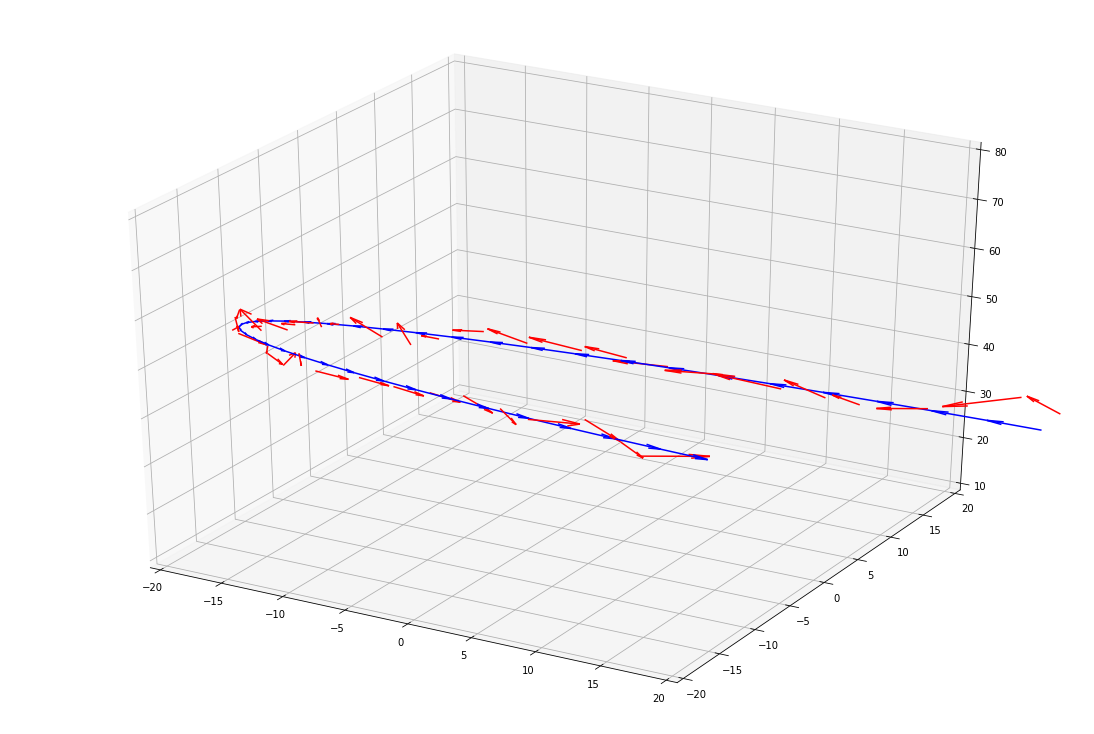

In [22]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

test_label_scaled4 = scaler.transform(test_label4)
pred2 = model2.predict(test_data4)
diff_scaled4 = pred2 - test_label_scaled4
mae_scaled4 = np.mean(abs(diff_scaled4))

test_predict4 = scaler.inverse_transform(pred2)
diff4 = test_predict4 - test_label_scaled4
mae_f4 = np.mean(abs(diff4))

test_predict_speed4 = test_predict4[:,3:] - test_predict4[:,:3]
test_label_speed4 = test_label4[:,3:] - test_label4[:,:3]
diff_speed4= test_predict_speed4 - test_label_speed4
mae_speed4 = np.mean(abs(diff_speed4))

for i in range(20):
    print(test_predict4[i] ,test_data_original_position4[i])
    N = test_predict4.shape[0]
    
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig)
ax.set_xlim3d(-20, 20)
ax.set_ylim3d(-20, 20)
ax.set_zlim3d(10, 80)
for i in range(N)[1:]:
    ax.quiver(test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2], 
              test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict4[i][0],test_predict4[i][1],test_predict4[i][2], 
              test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2], 
              length=1.0,
              color='r',
              label='Prediction')

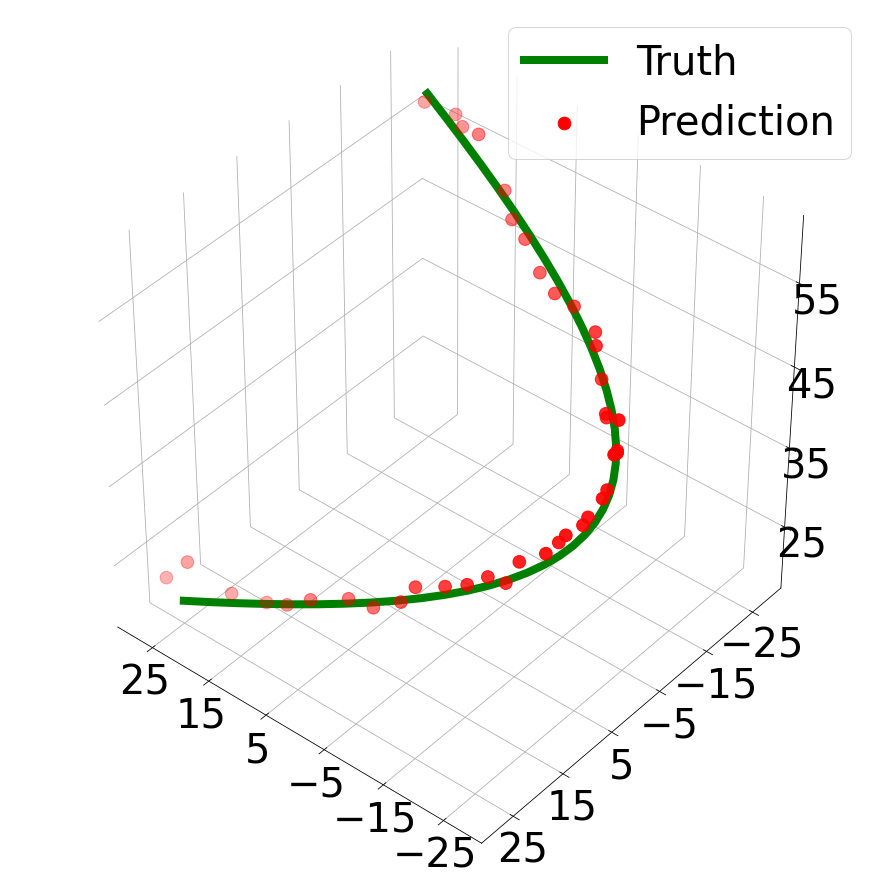

In [23]:
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
Test_4_Position = np.zeros((N,3))
Test_4_Position_speed = np.zeros((N,3))
Test_4_Predict = np.zeros((N,3))
Test_4_Predict_speed = np.zeros((N,3))
for i in range(N):
    Test_4_Position[i] = np.array([test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2]])
    Test_4_Position_speed[i] = np.array([test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2]])
    Test_4_Predict[i] = np.array([test_predict4[i][0],test_predict4[i][1],test_predict4[i][2]])
    Test_4_Predict_speed[i] = np.array([test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2]])
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-25, 25.1, 10), fontsize = 40)
plt.yticks(np.arange(-25, 25.1, 10), fontsize = 40)
ax.set_zticks(np.arange(25, 65.1, 10))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
fig.draw(fig.canvas.get_renderer())
plt.savefig('C:/Users/qoqud/Graph_12345.png')
plt.show()

xwhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,0], (N, 1))
ywhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,1], (N, 1))
twhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,2], (N, 1))
Array1 = np.concatenate((xwhole,ywhole,twhole), axis = 1)

xwhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,0], (N, 1))
ywhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,1], (N, 1))
twhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,2], (N, 1))
Array2 = np.concatenate((xwhole1,ywhole1,twhole1), axis = 1)

np.savetxt("./P_Truth_05_U_2.txt", Array1)
np.savetxt("./P_Predic_05_U_2.txt", Array2)

In [25]:
import os
from os import walk

def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".txt"):
                data = np.genfromtxt(root+'/'+file)
                (row,) = data.shape
                col = 1
                count += 1
            elif count != 0 and file.endswith(".txt"):
                data1 = np.genfromtxt(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = data.reshape((count, row, col))
    return data, count
Data2, c12 = dataload('C:/Data/03032023_Point_EN')
test_data4, test_data_original_position4, test_data_final_position4, test_label4 = data_preprocessing(Data2)


[ -0.86379683  -0.90786815  30.077002    -0.100527   -24.40832
  21.643795  ] [ 0.  0. 30.]
[ -0.85537827 -24.01372     21.02995     -3.069786   -22.792292
  22.18968   ] [-5.54414997e-15 -2.49686317e+01  2.00125465e+01]
[ -3.7792664 -24.072464   21.790304   -6.25207   -20.919044   22.042768 ] [ -3.90562963 -23.31343269  20.67707443]
[ -6.412591 -21.668129  21.92322  -10.46272  -19.144293  22.277676] [ -7.72087526 -21.50730705  21.35512352]
[-10.953585 -19.503021  22.057747 -14.500892 -17.89745   21.634125] [-11.34547329 -19.59521484  22.03309441]
[-15.107386 -17.895252  22.25605  -17.854696 -15.320794  22.705273] [-14.69051361 -17.58886528  22.71102905]
[-18.219006 -15.937953  23.368422 -19.903692 -13.617082  23.606083] [-17.6745472  -15.50004578  23.3891201 ]
[-19.945293 -13.751382  23.442698 -24.356188 -11.737621  27.462852] [-20.22234535 -13.34282875  24.06697845]
[-23.459705 -11.535028  26.74566  -24.591042  -8.892034  25.512276] [-22.27293777 -11.12918282  24.74502563]
[-24.16879

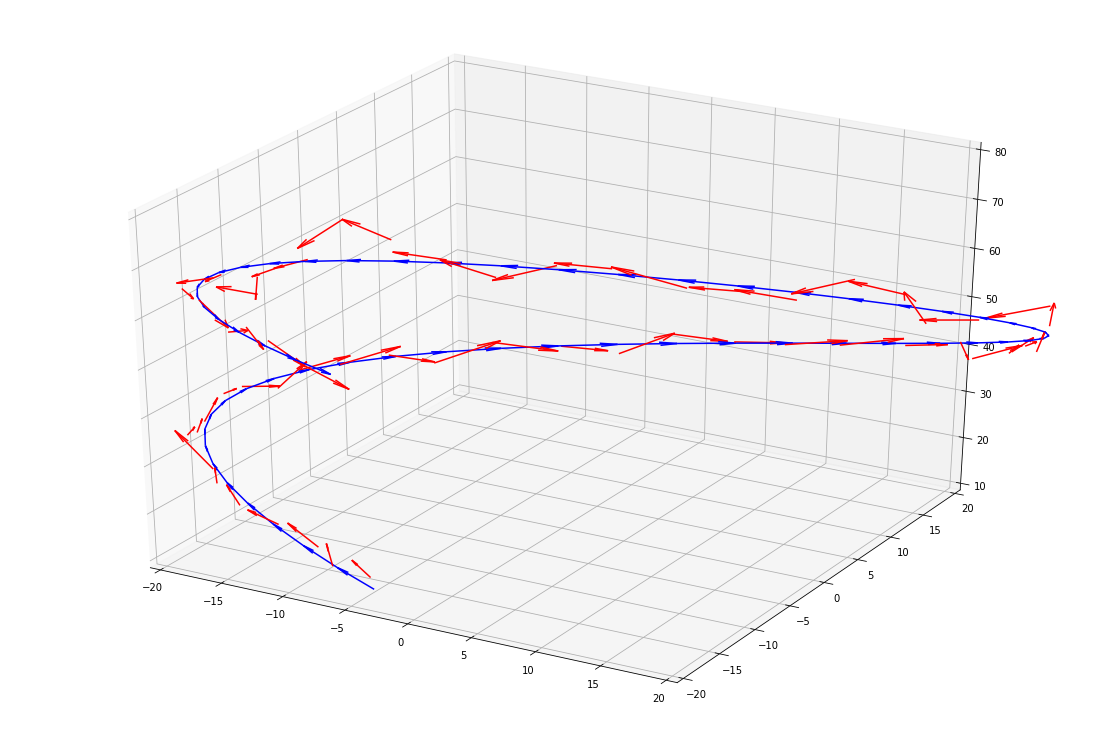

In [26]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

test_label_scaled4 = scaler.transform(test_label4)
pred2 = model2.predict(test_data4)
diff_scaled4 = pred2 - test_label_scaled4
mae_scaled4 = np.mean(abs(diff_scaled4))

test_predict4 = scaler.inverse_transform(pred2)
diff4 = test_predict4 - test_label_scaled4
mae_f4 = np.mean(abs(diff4))

test_predict_speed4 = test_predict4[:,3:] - test_predict4[:,:3]
test_label_speed4 = test_label4[:,3:] - test_label4[:,:3]
diff_speed4= test_predict_speed4 - test_label_speed4
mae_speed4 = np.mean(abs(diff_speed4))

for i in range(20):
    print(test_predict4[i] ,test_data_original_position4[i])
    N = test_predict4.shape[0]
    
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig)
ax.set_xlim3d(-20, 20)
ax.set_ylim3d(-20, 20)
ax.set_zlim3d(10, 80)
for i in range(N)[1:]:
    ax.quiver(test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2], 
              test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2], 
              length=1.0,
              color='b',
              label='Label')
    ax.quiver(test_predict4[i][0],test_predict4[i][1],test_predict4[i][2], 
              test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2], 
              length=1.0,
              color='r',
              label='Prediction')

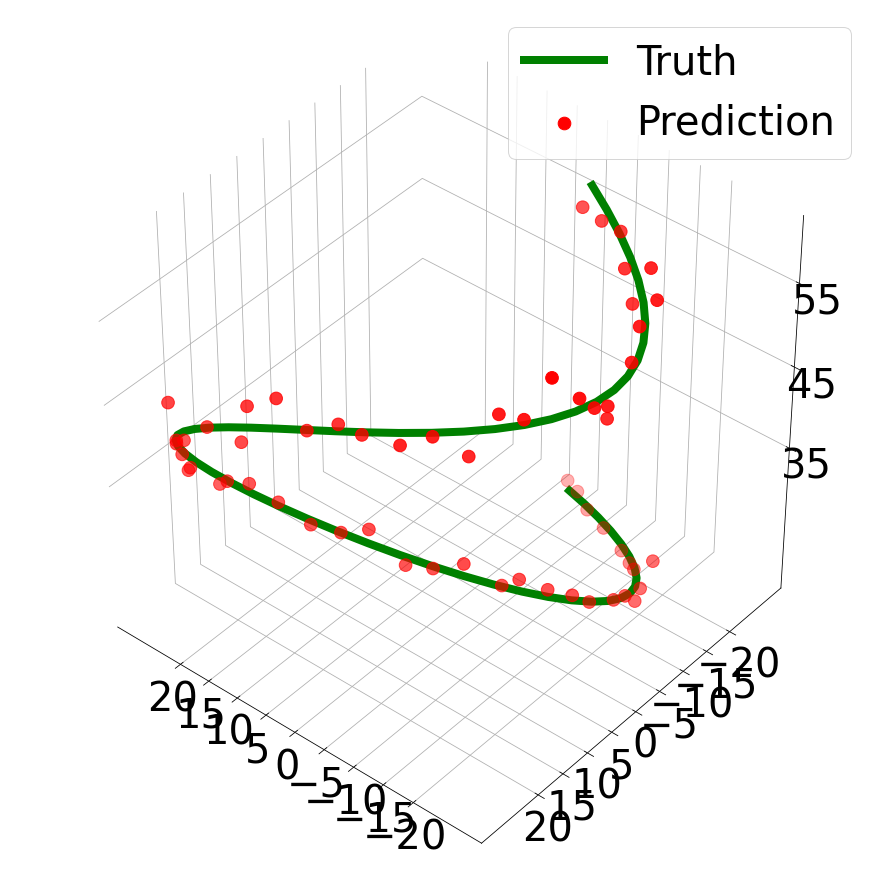

In [27]:
fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
Test_4_Position = np.zeros((N,3))
Test_4_Position_speed = np.zeros((N,3))
Test_4_Predict = np.zeros((N,3))
Test_4_Predict_speed = np.zeros((N,3))
for i in range(N):
    Test_4_Position[i] = np.array([test_data_original_position4[i][0],test_data_original_position4[i][1],test_data_original_position4[i][2]])
    Test_4_Position_speed[i] = np.array([test_label_speed4[i][0], test_label_speed4[i][1], test_label_speed4[i][2]])
    Test_4_Predict[i] = np.array([test_predict4[i][0],test_predict4[i][1],test_predict4[i][2]])
    Test_4_Predict_speed[i] = np.array([test_predict_speed4[i][0], test_predict_speed4[i][1], test_predict_speed4[i][2]])
ax.plot((Test_4_Position+Test_4_Position_speed)[:,0],(Test_4_Position+Test_4_Position_speed)[:,1],(Test_4_Position+Test_4_Position_speed)[:,2]
        ,c='g', label= 'Truth', linewidth = 8)
ax.scatter((Test_4_Predict+Test_4_Predict_speed)[:,0],(Test_4_Predict+Test_4_Predict_speed)[:,1],(Test_4_Predict+Test_4_Predict_speed)[:,2]
        ,c='r', marker='o', s = 160, label='Prediction')
plt.legend(fontsize=40)
plt.xticks(np.arange(-20, 20.1, 5), fontsize = 40)
plt.yticks(np.arange(-20, 20.1, 5), fontsize = 40)
ax.set_zticks(np.arange(35, 70.1, 10))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.axis([-30, 30, -30, 30])
ax.tick_params(axis='z', labelsize= 40)
ax.view_init(40, 130)
fig.draw(fig.canvas.get_renderer())
plt.savefig('C:/Users/qoqud/Graph_12345.png')
plt.show()

xwhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,0], (N, 1))
ywhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,1], (N, 1))
twhole = np.reshape((Test_4_Position+Test_4_Position_speed)[:,2], (N, 1))
Array1 = np.concatenate((xwhole,ywhole,twhole), axis = 1)

xwhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,0], (N, 1))
ywhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,1], (N, 1))
twhole1 = np.reshape((Test_4_Predict+Test_4_Predict_speed)[:,2], (N, 1))
Array2 = np.concatenate((xwhole1,ywhole1,twhole1), axis = 1)

np.savetxt("./P_Truth_06_Sine.txt", Array1)
np.savetxt("./P_Predic_06_Sine.txt", Array2)